### Import Packages

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools
import warnings
warnings.filterwarnings('ignore')

### Read Data

In [18]:
edata=pd.read_csv('C:/Users/shamebanerjee/Desktop/Personal_Stuff_1/Analytics/ML/Class 11 & 12/0. Tractor Sales forecasting - Class Exercise/Electricity Consumption.csv')

In [19]:
edata.head()

DATE  Electricty_Consumption_in_TW
0  1/1/1973                       35.9728
1  2/1/1973                       36.1334
2  3/1/1973                       35.0625
3  4/1/1973                       33.8416
4  5/1/1973                       33.5107

In [20]:
edata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


### Data Preparation

In [21]:
# Convert Date from object to Datetime

edata['DATE']=pd.to_datetime(edata.DATE)

In [22]:
# Convert Data to Time series

edata.set_index(edata.DATE,inplace=True)

In [23]:
edata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 561 entries, 1973-01-01 to 2019-09-01
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          561 non-null    datetime64[ns]
 1   Electricty_Consumption_in_TW  561 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.1 KB


In [24]:
edata.head()

DATE  Electricty_Consumption_in_TW
DATE                                               
1973-01-01 1973-01-01                       35.9728
1973-02-01 1973-02-01                       36.1334
1973-03-01 1973-03-01                       35.0625
1973-04-01 1973-04-01                       33.8416
1973-05-01 1973-05-01                       33.5107

In [25]:
# Creating Month and Year (This will be required later for identifying trend and seasonality)

edata['Month']=edata.DATE.dt.month
edata['Year']=edata.DATE.dt.year

In [26]:
edata.head()

DATE  Electricty_Consumption_in_TW  Month  Year
DATE                                                            
1973-01-01 1973-01-01                       35.9728      1  1973
1973-02-01 1973-02-01                       36.1334      2  1973
1973-03-01 1973-03-01                       35.0625      3  1973
1973-04-01 1973-04-01                       33.8416      4  1973
1973-05-01 1973-05-01                       33.5107      5  1973

In [75]:
#Extracting Time Series Data

ts=edata.Electricty_Consumption_in_TW.round(2)

In [76]:
ts.head()

DATE
1973-01-01    35.97
1973-02-01    36.13
1973-03-01    35.06
1973-04-01    33.84
1973-05-01    33.51
Name: Electricty_Consumption_in_TW, dtype: float64

### Exploratory Data Analysis (EDA)

In [77]:
# Here we can see that there is seasonality
pd.pivot_table(data=edata,index='Month',columns='Year',values='Electricty_Consumption_in_TW').plot(legend=False)

<AxesSubplot:xlabel='Month'>

In [78]:
#We can see there is a positive linear trend

pd.pivot_table(data=edata,index='Year',columns='Month',values='Electricty_Consumption_in_TW').plot(legend=False)

<AxesSubplot:xlabel='Year'>

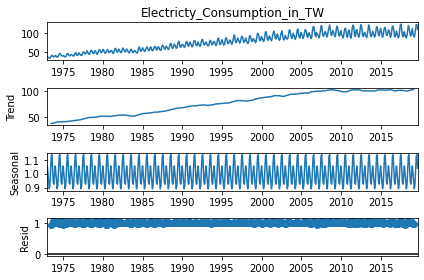

In [90]:
#Verify Seasonality and Trend

decomp=seasonal_decompose(ts,model='multiplicative')
decomp.plot()

In [91]:
pd.concat([decomp.observed,decomp.trend,decomp.seasonal,decomp.resid],axis=1).head(10)

Electricty_Consumption_in_TW      trend  seasonal     resid
DATE                                                                   
1973-01-01                         35.97        NaN  1.055366       NaN
1973-02-01                         36.13        NaN  0.996077       NaN
1973-03-01                         35.06        NaN  0.945341       NaN
1973-04-01                         33.84        NaN  0.890881       NaN
1973-05-01                         33.51        NaN  0.918779       NaN
1973-06-01                         36.48        NaN  1.030846       NaN
1973-07-01                         39.14  37.220833  1.125752  0.934097
1973-08-01                         41.41  37.574167  1.136100  0.970062
1973-09-01                         40.16  37.848333  1.038774  1.021471
1973-10-01                         37.11  38.070833  0.936696  1.040639

### ETS (Exponential Smoothing)

In [116]:
# UDF to Find the best parameter

def exp_sm (timeseries,val_split_date,alpha=[None],beta=[None],gamma=[None],trend=None,seasonal=None,period=None,verbose=False):
    
    best_params=[]
    actual=timeseries[val_split_date:]
    
    for a in alpha:
        for b in beta:
            for g in gamma:
                
                if(verbose==True):
                    
                    print('checking for' ,'alpha :', a , ' beta : ', b , ' and gamma : ', g)
                    
                    model=ExponentialSmoothing(timeseries,trend=trend,seasonal=seasonal,seasonal_periods=period)
                    model.fit(smoothing_level=a,smoothing_slope=b,smoothing_seasonal=g)
                    f_cast=model.predict(model.params,start=actual.index[0])
                    score=mean_absolute_percentage_error(actual,f_cast)
                    
                    best_params.append({'alpha': a, 'beta': b, 'gamma': g, 'mape': score})
                    
    return min(best_params,key= lambda x: x['mape'])

In [130]:
# Defining alpha,beta and gamma values

alpha = [0.1,0.2,0.3,0.4,0.5,0.6]
beta = [0.1,0.2,0.3,0.4,0.5,0.6]
gamma =[0.1,0.2,0.3,0.4,0.5,0.6]

In [131]:
#Function Call 
exp_sm(ts, val_split_date ='2019-01-04' , alpha=alpha, beta=beta, gamma=gamma, 
              trend='mul', seasonal='mul', period=12, verbose=True)

checking for alpha : 0.1  beta :  0.1  and gamma :  0.1
checking for alpha : 0.1  beta :  0.1  and gamma :  0.2
checking for alpha : 0.1  beta :  0.1  and gamma :  0.3
checking for alpha : 0.1  beta :  0.1  and gamma :  0.4
checking for alpha : 0.1  beta :  0.1  and gamma :  0.5
checking for alpha : 0.1  beta :  0.1  and gamma :  0.6
checking for alpha : 0.1  beta :  0.2  and gamma :  0.1
checking for alpha : 0.1  beta :  0.2  and gamma :  0.2
checking for alpha : 0.1  beta :  0.2  and gamma :  0.3
checking for alpha : 0.1  beta :  0.2  and gamma :  0.4
checking for alpha : 0.1  beta :  0.2  and gamma :  0.5
checking for alpha : 0.1  beta :  0.2  and gamma :  0.6
checking for alpha : 0.1  beta :  0.3  and gamma :  0.1
checking for alpha : 0.1  beta :  0.3  and gamma :  0.2
checking for alpha : 0.1  beta :  0.3  and gamma :  0.3
checking for alpha : 0.1  beta :  0.3  and gamma :  0.4
checking for alpha : 0.1  beta :  0.3  and gamma :  0.5
checking for alpha : 0.1  beta :  0.3  and gamma

{'alpha': 0.1, 'beta': 0.4, 'gamma': 0.3, 'mape': 0.006862227042984457}

In [132]:
#Build Model with Best Parameters

expsm_model=ExponentialSmoothing(ts,trend='mul',seasonal='mul',seasonal_periods=12).fit(smoothing_level=0.1,smoothing_slope=0.4,smoothing_seasonal=0.3)
print(expsm_model.summary())

                           ExponentialSmoothing Model Results                           
Dep. Variable:     Electricty_Consumption_in_TW   No. Observations:                  561
Model:                     ExponentialSmoothing   SSE                           3427.621
Optimized:                                 True   AIC                           1047.354
Trend:                           Multiplicative   BIC                           1116.630
Seasonal:                        Multiplicative   AICC                          1048.616
Seasonal Periods:                            12   Date:                 Fri, 02 Dec 2022
Box-Cox:                                  False   Time:                         16:05:53
Box-Cox Coeff.:                            None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.100

### Check Accuracy of the Model

In [134]:
#Train Test Split
train=ts[:'2019-04-01']
test=ts['2019-05-01':]

In [141]:
#Check Accuracy on Test

expsm_model=ExponentialSmoothing(train,trend='mul',seasonal='mul',seasonal_periods=12).fit(smoothing_level=0.1,smoothing_slope=0.4,smoothing_seasonal=0.3)
pred_test=expsm_model.forecast(5)
print('Mape on Test ' , mean_absolute_percentage_error(test,pred_test)*100,
      '|| RMSE on Test ', np.sqrt(mean_squared_error(test,pred_test)),
'|| RMSPE on Test', np.sqrt(np.nanmean(np.square(((test - pred_test) / test))))*100)



Mape on Test  1.068362000184053 || RMSE on Test  1.4219998181235014 || RMSPE on Test 1.4098945935908525


In [142]:
#Check Accuracy on Train

pred_train=expsm_model.fittedvalues[:'2019-04-01']
print('Mape on Train ' , mean_absolute_percentage_error(train,pred_train)*100,
      '|| RMSE on Train ', np.sqrt(mean_squared_error(train,pred_train)),
'|| RMSPE on Train', np.sqrt(np.nanmean(np.square(((train - pred_train) / train))))*100)

Mape on Train  2.3780720488943508 || RMSE on Train  2.47996720213175 || RMSPE on Train 3.063238552516402


### SARIMA (As seen previously we have seasonality in the data and so we will build a SARIMA model)

#### Box Jenkins to find the approx values of p,d,q and applying SARIMA

In [143]:
### We need to ensure series is stationary

adfuller(ts)

(-1.7404754264018862,
 0.4103881457965056,
 15,
 545,
 {'1%': -3.442405720052601,
  '5%': -2.866857804790472,
  '10%': -2.5696022094099824},
 2295.6536417942525)

In [144]:
#Here d=1

adfuller(ts.diff(1).dropna())


(-7.939831773622087,
 3.3368754457946933e-12,
 14,
 545,
 {'1%': -3.442405720052601,
  '5%': -2.866857804790472,
  '10%': -2.5696022094099824},
 2292.7938384699746)

In [145]:
#Check for Autocorrelation using ACF test
diff_sales=ts.diff(1).dropna()
smt.acf(diff_sales) # Here we see there is autocorrelaton with different lags

array([ 1.        ,  0.42977888, -0.38293849, -0.77091826, -0.42672412,
        0.32054118,  0.67286785,  0.31657477, -0.43226745, -0.76549712,
       -0.34559002,  0.442187  ,  0.90853036,  0.42471549, -0.36789359,
       -0.76196668, -0.4038689 ,  0.3270445 ,  0.65285777,  0.30885396,
       -0.41802959, -0.75321357, -0.33985784,  0.44482276,  0.87125897,
        0.40738258, -0.35744299, -0.74247551])

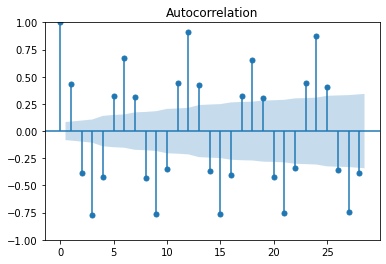

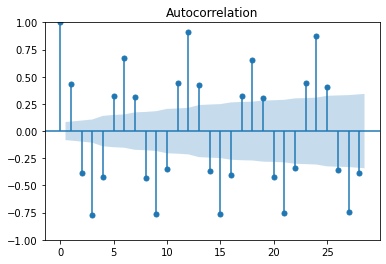

In [146]:
# Series is seasonal - SARIMA Model
# q value based on ACF plot
# value of q = 1, Q=1
# q value founded based after which value of lag, the correlations becoming zero or crossing zero (positive to negative or negative to positive)
smt.graphics.plot_acf(diff_sales) 

In [147]:
#Find PACF

smt.pacf(diff_sales)

array([ 1.        ,  0.43054772, -0.6993154 , -0.46320723, -0.16171692,
        0.18497076,  0.00369826, -0.17660898, -0.50106817, -0.48090161,
       -0.50301742, -0.40701015,  0.349586  ,  0.05668744,  0.11960545,
       -0.07892538, -0.00442633,  0.01035299, -0.05999759,  0.06393023,
        0.06924211, -0.03390082, -0.22040604, -0.14875768,  0.06360729,
       -0.01183722,  0.05412797, -0.00948026])

In [148]:
#Find p value based on PACF plot
# value of p = 1, P=1
# p value founded based after which value of lag, the correlations becoming zero or crossing zero (positive to negative or negative to positive)

smt.graphics.plot_pacf(diff_sales,lags=24,method='ols')

In [163]:
#Train-Test split
train1=ts[:'2019-01-01']
test1=ts['2019-02-01':]

In [164]:
#Applying SARIMA with parametres from Box Jenkins test
msm_1=sm.tsa.statespace.SARIMAX(train1,order = (1,1,1), seasonal_order= (1,0,1,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False).fit()

In [165]:
print(msm_1.summary()) # AIC value should be as low as possible 

                                     SARIMAX Results                                      
Dep. Variable:       Electricty_Consumption_in_TW   No. Observations:                  553
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1069.777
Date:                            Fri, 02 Dec 2022   AIC                           2149.554
Time:                                    16:46:49   BIC                           2170.993
Sample:                                01-01-1973   HQIC                          2157.940
                                     - 01-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5949      0.046     12.974      0.000       0.505       0.685
ma.L1         -0.9116      0.026   

#### Check Accuracy for the model

In [166]:
#Test Accuracy
pred_test1=msm_1.forecast(8)

print('Mape on Test ' , mean_absolute_percentage_error(test1,pred_test1)*100,
      '|| RMSE on Test ', np.sqrt(mean_squared_error(test1,pred_test1)),
'|| RMSPE on Test', np.sqrt(np.nanmean(np.square(((test1 - pred_test1) / test1))))*100)

Mape on Test  1.9164459482093852 || RMSE on Test  2.4156657307538665 || RMSPE on Test 2.436590579721495


In [167]:
#Train Accuracy

pred_train1=msm_1.fittedvalues[:'2019-01-01']

print('Mape on Test ' , mean_absolute_percentage_error(train1,pred_train1)*100,
      '|| RMSE on Test ', np.sqrt(mean_squared_error(train1,pred_train1)),
'|| RMSPE on Test', np.sqrt(np.nanmean(np.square(((train1 - pred_train1) / train1))))*100)

Mape on Test  2.02708573156483 || RMSE on Test  2.4444804109114666 || RMSPE on Test 5.183158811943651


#### Iterative method to find the best values of p,d,q

In [151]:
def auto_sarima(timeseries,regressors=None,p=range(0, 2), d=range(0, 2), q=range(0, 2),
              P=range(0, 2), D=range(0, 1), Q=range(0, 2)):
    
    # Generate all different combinations of p, d and q triplets
    pdq=list(itertools.product(p,d,q))
    
    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq=[(x[0],x[1],x[2],12) for x in list(itertools.product(P,D,Q))]
    
    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            
            temp_model=sm.tsa.statespace.SARIMAX(endog=timeseries,exog=regressors,order=param,seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                 enforce_invertibility=False)
            
            temp_results = temp_model.fit()
            
            print("SARIMAX{}x{} - AIC:{}".format(param, param_seasonal, temp_results.aic))
            
            if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
                    
    
    print("Best SARIMAX{}x{} model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])

In [152]:
best_results=auto_sarima(ts,p=range(0,3),d=range(0, 2),q=range(0,3),P=range(0,3),D=range(0,2),Q=range(0,3))

SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:6499.620322849492
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:5676.895617859987
SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:4980.9985509810895
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:2816.721754417154
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:2754.818258558505
SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:2697.3871982792166
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:2733.159930607857
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:2707.2165764404886
SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:2649.656493067684
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:2758.984273143656
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:2659.5709763557256
SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:2540.5053045899085
SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:2652.2078478679346
SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:2653.3211722551105
SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:2650.9439607204495
SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:2698.8475169902686
SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:2569.227828501842
SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:2542.505077597126
S

In [168]:
#Applying SARIMA with parametres from Iterative Approach
msm_2=sm.tsa.statespace.SARIMAX(train1,order = (1,1,2), seasonal_order= (2,1,2,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False).fit()

In [169]:
print(msm_2.summary()) # AIC value should be as low as possible 

                                     SARIMAX Results                                      
Dep. Variable:       Electricty_Consumption_in_TW   No. Observations:                  553
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -1029.551
Date:                            Fri, 02 Dec 2022   AIC                           2075.103
Time:                                    16:50:54   BIC                           2109.025
Sample:                                01-01-1973   HQIC                          2088.399
                                     - 01-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3891      0.084      4.614      0.000       0.224       0.554
ma.L1         -0.6538      0.086   

#### Check Accuracy of the model

In [171]:
#Test Accuracy
pred_test2=msm_2.forecast(8)

print('Mape on Test ' , mean_absolute_percentage_error(test1,pred_test2)*100,
      '|| RMSE on Test ', np.sqrt(mean_squared_error(test1,pred_test2)),
'|| RMSPE on Test', np.sqrt(np.nanmean(np.square(((test1 - pred_test2) / test1))))*100)

Mape on Test  3.13446905228181 || RMSE on Test  3.638317931938048 || RMSPE on Test 3.4255410311970484


In [172]:
#Train Accuracy

pred_train2=msm_2.fittedvalues[:'2019-01-01']

print('Mape on Test ' , mean_absolute_percentage_error(train1,pred_train2)*100,
      '|| RMSE on Test ', np.sqrt(mean_squared_error(train1,pred_train2)),
'|| RMSPE on Test', np.sqrt(np.nanmean(np.square(((train1 - pred_train2) / train1))))*100)

Mape on Test  2.1327468253194355 || RMSE on Test  2.596688738412321 || RMSPE on Test 5.592694703837648


### Final Conclusion and Forecast

In [174]:
expsm_model=ExponentialSmoothing(ts,trend='mul',seasonal='mul',seasonal_periods=12).fit(smoothing_level=0.1,smoothing_slope=0.4,smoothing_seasonal=0.3)
expsm_model.forecast(24)

2019-10-01     97.702180
2019-11-01     95.581143
2019-12-01    106.205716
2020-01-01    113.501327
2020-02-01    103.434901
2020-03-01    100.044086
2020-04-01     94.468462
2020-05-01    101.823957
2020-06-01    117.385430
2020-07-01    129.948774
2020-08-01    129.230586
2020-09-01    116.229867
2020-10-01    103.696890
2020-11-01    101.445713
2020-12-01    112.722177
2021-01-01    120.465425
2021-02-01    109.781354
2021-03-01    106.182488
2021-04-01    100.264760
2021-05-01    108.071567
2021-06-01    124.587845
2021-07-01    137.922038
2021-08-01    137.159783
2021-09-01    123.361380
Freq: MS, dtype: float64